In [1]:
import math
from collections import Counter

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from konlpy.tag import Mecab

In [2]:
def preprocessing(series: pd.Series):
    series = series.str.replace('\n', ' ')
    series = series.str.replace(r'[ㄱ-ㅎㅏ-ㅣ ]', ' ', regex=True)
    series = series.str.replace(r'[^0-9가-힣,.!? ]', '', regex=True)
    series = series.str.replace('번역 제공', '', regex=True)
    series = series.str.replace(r' *[.!?]+ *', '.', regex=True)
    series = series.str.replace('\.([0-9]+)\.', '', regex=True)
    series = series.str.replace(r'^[. ]+', '', regex=True)
    series = series.str.replace(' +', ' ', regex=True)
    return series

In [3]:
review = pd.read_csv('./data/total_sample_01.csv', index_col=0)

In [4]:
review = review.dropna(subset=['review'], axis=0).reset_index(drop=True)
review['review'] = preprocessing(review['review'])

In [5]:
tokenizer = Mecab().pos
review['tokenized'] = review['review'].map(tokenizer)

In [6]:
review['tokenized']

0        [(소스, NNG), (가, JKS), (츠, IC), (동, NNG), (은, J...
1        [(구성, NNG), (이, JKS), (좋, VA), (아요, EC), (가, V...
2        [(메뉴, NNG), (하나하나, MAG), (다, MAG), (매력, NNG), ...
3        [(여기, NP), (맛있, VA), (어요, EF), (., SF), (소스, N...
4        [(코돈, NNG), (부르, VV), (에다가, EC), (시원, XR), (한,...
                               ...                        
29806    [(분위기, NNG), (맛집, NNG), (이, VCP), (고, EC), (음식...
29807    [(크리스마스, NNP), (라고, VCP+EC), (꽃, NNG), (준비, NN...
29808    [(사시미, NNG), (도, JX), (맛있, VA), (고, EC), (츠, I...
29809    [(통꽃, NNG), (게, NNG), (로제, NNG), (파스타, NNG), (...
29810        [(풋사과, NNG), (하이볼, NNG), (최고, NNG), (크으, IC)]
Name: tokenized, Length: 29811, dtype: object

In [7]:
target_pos = ['MAG', 'NNG', 'NNP', 'VA', 'XR']

mecab_target_pos = [[token_pos[0] for token_pos in token_pos_s if token_pos[1] in target_pos]
                    for token_pos_s in review['tokenized']]
review['tokenized'] = pd.Series(mecab_target_pos)

In [8]:
review.head()

,name,review,review_tags,tokenized
0,카린지린가네스낵바 신촌점,소스가츠동은 진짜 먹어본 다른 가츠동이랑은 다르네요.더 바삭하고 씹는 식감이 있어요...,"혼밥하기 좋아요, 인테리어가 멋져요","[소스, 동, 진짜, 동이, 다르, 더, 바삭, 식감, 있, 고기, 묵직, 양, 많..."
1,카린지린가네스낵바 신촌점,구성이 좋아요 가게 분위기도 재밌고 또 가고 싶게 만드는 매력이 되게 많아요,"음식이 맛있어요, 재료가 신선해요, 특별한 메뉴가 있어요, 인테리어가 멋져요","[구성, 좋, 분위기, 재밌, 또, 매력, 되게, 많]"
2,카린지린가네스낵바 신촌점,메뉴하나하나 다 매력있어요 담에는 오뎅모리에 사케한잔해야겠어요,"음식이 맛있어요, 특별한 메뉴가 있어요, 재료가 신선해요, 양이 많아요, 친절해요","[메뉴, 하나하나, 다, 매력, 있, 담, 오뎅, 모리, 한잔]"
3,카린지린가네스낵바 신촌점,여기 맛있어요.소스카츠동 왕추천드려요 한번 먹어보세요 기가맥혀요,"화장실이 깨끗해요, 양이 많아요","[맛있, 소스, 카츠, 왕, 추천]"
4,카린지린가네스낵바 신촌점,코돈부르에다가 시원한 생맥주한잔 조합이 너무 좋았어요 대박이에요,"특별한 메뉴가 있어요, 인테리어가 멋져요","[코돈, 시원, 생맥주, 한잔, 조합, 너무, 좋, 대박]"


In [9]:
vocab = list(set(sum(review['tokenized'], [])))

In [10]:
N = len(review)

def tf(doc, word):
    return doc.count(word)

def idf(word, column):
    df = 0
    for tokens in review[column]:
        if word in tokens:
            df += 1
    return math.log(N / (1+df))

In [11]:
def create_tf(column, vocab=vocab):
    result = []
    for i in tqdm(range(N)):
        result.append([])
        doc = review[column].iloc[i]
        for j in range(len(vocab)):
            word = vocab[j]
            result[-1].append(tf(doc, word))
    return pd.DataFrame(result, columns=vocab)

def create_idf(column, vocab):
    result = []
    for j in tqdm(range(len(vocab))):
        word = vocab[j]
        result.append(idf(word, column))
    return pd.DataFrame(result, index=vocab, columns=['IDF'])

def cal_tfidf(column, vocab=vocab):
    tf_ = create_tf(column, vocab)
    idf_ = create_idf(column, vocab)
    idf_ = pd.DataFrame(
        np.repeat(idf_.T.values, tf_.index.size, axis=0), columns=idf_.T.columns)
    return tf_.mul(idf_)

In [12]:
tfidf_total = cal_tfidf('tokenized', vocab=vocab)

100%|██████████| 10500/10500 [01:44<00:00, 100.65it/s]


In [13]:
tfidf_temp = tfidf_total.apply(dict, axis=1)

In [14]:
result = []
for t in tqdm(tfidf_temp):
    temp_dict = {}
    for k, v in t.items():
        if v != 0:
            temp_dict[k] = v
    result.append(temp_dict)

100%|██████████| 29811/29811 [00:34<00:00, 872.24it/s] 


In [15]:
temp_tfidf = {i: sorted(result[i].items(), key=lambda item: item[1], reverse=True) for i in range(len(result))}

In [16]:
tfidf_score = tfidf_total.max(axis=0).sort_values(ascending=False)

In [17]:
top_score_in_sentence = []
for i, t in temp_tfidf.items():
    try:
        top_score_in_sentence.append(t[0][0])
    except:
        continue
counter = Counter(top_score_in_sentence)

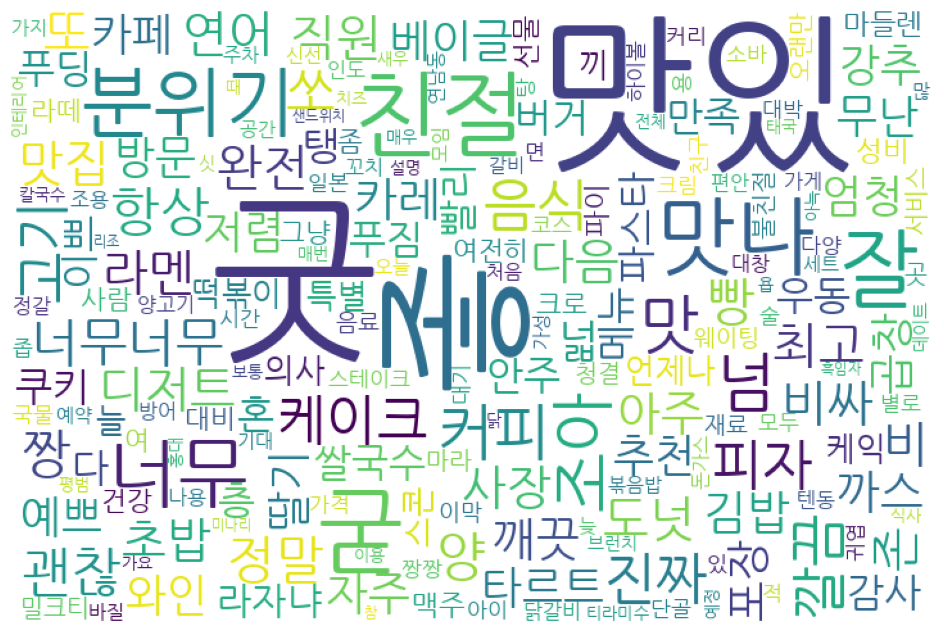

In [18]:
wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic', 
               background_color='white', 
               max_font_size=140,
               width=720,
               height=480)
cloud = wc.generate_from_frequencies(counter)
plt.figure(figsize=(12, 8))
plt.imshow(cloud)
plt.axis('off')
plt.show()